# Marelle Board import
* Getting players info dict => `MarelleBoard.players`
* 3 phases : place, move and end => `MarelleBoard.phase`
* Reset the board => `MarelleBoard.initialize_game()`
* Printing the board => `MarelleBoard.print_board()`
* Id:Action dict => `MarelleBoard.id_to_action`
* Action:Id dict => `MarelleBoard.action_to_id`
* Get the board state => `MarelleBoard.get_state()`
* Play an action => `MarelleBoard.play_action(action_id, player)`
* Get legal action ids => `MarelleBoard.get_legal_action_ids(player)`
* Check if game ended (returns 0 if not ended or winning player id) : `MarelleBoard.check_if_end(player)`

In [5]:
import importlib

import marl_env
import marl_agents
import marl_models
import marl_evaluations
importlib.reload(marl_env)
importlib.reload(marl_agents)
importlib.reload(marl_models)
importlib.reload(marl_evaluations)

from marl_env import MarelleBoard, MarelleGymEnv, MarelleGame
from marl_models import FCModel, ConvModel
from marl_agents import RandomAgent, BetterRandomAgent, SingleModelReinforce, ReinforceAgent, MarelleAgent
from marl_train import train_agent, adversarial_training
from marl_evaluations import evaluate

import progressbar as pb
import numpy as np 
import os
import cProfile

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb

import torch
import torch.nn as nn

# Training


In [9]:
# ACTOR CRITIC !!
# TRIPLE ACTION NETWORK !!
# DeepL style network
# Q learning

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Restoring Models

In [3]:
def load_model_wandb(model_name, run_id, model):
    wandb.restore(model_name, run_path=f'clement-guillo/marl/{run_id}',root= "models/temp/")
    model.load_state_dict(torch.load(f'models/temp/{model_name}'))
    os.remove(f'models/temp/{model_name}')
    return(model)

def load_model_local(model_name, model):
    model.load_state_dict(torch.load(f'models/{model_name}'))
    return(model)

## Full game training

In [6]:
env = MarelleGymEnv(end_after_place_phase=False)

# Initiate Models
#einstein_fc_model = FCModel(env.N_STATE, env.N_TOTAL_ACTIONS)
einstein_conv_model = ConvModel(env.N_TOTAL_ACTIONS)

# Restore models from previous trainings
# einstein_conv_model=load_model_local("3w3zmj5x_SingleModel_Conv_500epochs_1000trajectories_20201116_55%win.pt",ConvModel(env.N_TOTAL_ACTIONS))

# Agents
#einstein_fc = SingleModelReinforce(env=env, model=einstein_fc_model, lr=0.005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)
einstein_conv = SingleModelReinforce(env=env, model=einstein_conv_model, lr=0.0001, win_reward=1, defeat_reward=-1, capture_reward=0, captured_reward=0, epsilon=0.1, gamma=1)

# Opponents
opponent_agent=BetterRandomAgent(env)
evaluate_agent=BetterRandomAgent(env)

# Training Conv agent
train_agent(
    env=env,
    n_epochs=1000,
    n_trajectories=2000,
    trained_agent=einstein_conv,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=True,
    save_model_freq=50,
    evaluate_freq= 5
)

episode,59
rewards,-0.95
+/-,0.31
loss,-41.28786
_step,59
_runtime,736
_timestamp,1605811222
n_actions,47.883
n_captures_place,0.065
n_captured_place,1.982
n_captures_move,0.667


episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rewards,▆▃▃▃▄▄▄▆▃▆▅▃█▃▅▄▅▄▃▄▃▅▆▃▆▃▅▅▁▄▂▄▄▃▃▄▃▆▂▅
+/-,▇▅▄▅▆▆▆▇▅▇▆▄█▄▆▆▆▆▄▆▅▆▇▄▇▅▆▆▁▆▃▆▆▅▅▆▅▇▃▆
loss,▇▅▃▂▅▄▅▅▄▅▅▃█▂▃▄▄▆▁▆▅▆▃▄▇▃▇█▃▅▁▄▃▃▄▄▅▆▂▇
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
n_actions,▁▁▃▄▄▆▆▁▄█▄
n_captures_place,▅▃▅█▇▄▇▁▁▇▁
n_captured_place,▆█▆▁▅▁▁▆▆▄▇
n_captures_move,▁▂▃▅▆▆█▂▅█▆


wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Episode 1/1000: rewards -0.95 +/- 0.31 - Loss : -42.691627502441406


Episode 2/1000: rewards -0.96 +/- 0.27 - Loss : -44.428314208984375


Episode 3/1000: rewards -0.96 +/- 0.28 - Loss : -43.63343811035156


Episode 4/1000: rewards -0.96 +/- 0.27 - Loss : -44.43998336791992


Episode 5/1000: rewards -0.96 +/- 0.27 - Loss : -43.60102462768555


{'n_actions': 44.138, 'n_captures_place': 0.18, 'n_captured_place': 1.965, 'n_captures_move': 0.65, 'n_captured_move': 4.98, 'draws_%': 0.0, 'victories_capture_%': 0.018, 'victories_block_%': 0.0, 'defeats_capture_%': 0.97, 'defeats_block_%': 0.013}


Episode 6/1000: rewards -0.96 +/- 0.26 - Loss : -43.95747375488281


Episode 7/1000: rewards -0.94 +/- 0.34 - Loss : -42.682979583740234


Episode 8/1000: rewards -0.96 +/- 0.28 - Loss : -43.96598815917969


Episode 9/1000: rewards -0.97 +/- 0.23 - Loss : -44.42848587036133


Episode 10/1000: rewards -0.96 +/- 0.27 - Loss : -43.8811149597168


{'n_actions': 45.398, 'n_captures_place': 0.217, 'n_captured_place': 1.868, 'n_captures_move': 0.83, 'n_captured_move': 4.975, 'draws_%': 0.0, 'victories_capture_%': 0.033, 'victories_block_%': 0.0, 'defeats_capture_%': 0.96, 'defeats_block_%': 0.007}


Episode 11/1000: rewards -0.96 +/- 0.28 - Loss : -43.295169830322266


Episode 12/1000: rewards -0.97 +/- 0.24 - Loss : -44.39902114868164


Episode 13/1000: rewards -0.98 +/- 0.21 - Loss : -44.39535903930664


Episode 14/1000: rewards -0.96 +/- 0.27 - Loss : -43.01937484741211


Episode 15/1000: rewards -0.97 +/- 0.26 - Loss : -44.52060317993164


{'n_actions': 44.83, 'n_captures_place': 0.205, 'n_captured_place': 1.955, 'n_captures_move': 0.71, 'n_captured_move': 4.898, 'draws_%': 0.003, 'victories_capture_%': 0.033, 'victories_block_%': 0.0, 'defeats_capture_%': 0.942, 'defeats_block_%': 0.022}


Episode 16/1000: rewards -0.97 +/- 0.25 - Loss : -44.06865310668945


Episode 17/1000: rewards -0.94 +/- 0.33 - Loss : -42.69721603393555


Episode 18/1000: rewards -0.96 +/- 0.27 - Loss : -43.20199203491211


Episode 19/1000: rewards -0.95 +/- 0.31 - Loss : -42.0229377746582


Episode 20/1000: rewards -0.97 +/- 0.26 - Loss : -43.86416244506836


{'n_actions': 43.453, 'n_captures_place': 0.232, 'n_captured_place': 1.985, 'n_captures_move': 0.588, 'n_captured_move': 4.897, 'draws_%': 0.0, 'victories_capture_%': 0.028, 'victories_block_%': 0.0, 'defeats_capture_%': 0.94, 'defeats_block_%': 0.033}


Episode 21/1000: rewards -0.94 +/- 0.33 - Loss : -42.02651596069336


Episode 22/1000: rewards -0.96 +/- 0.27 - Loss : -43.24948501586914


Episode 23/1000: rewards -0.96 +/- 0.29 - Loss : -43.03895568847656


Episode 24/1000: rewards -0.96 +/- 0.28 - Loss : -43.817806243896484


Episode 25/1000: rewards -0.96 +/- 0.27 - Loss : -44.18229675292969


{'n_actions': 46.555, 'n_captures_place': 0.185, 'n_captured_place': 1.805, 'n_captures_move': 0.625, 'n_captured_move': 5.11, 'draws_%': 0.0, 'victories_capture_%': 0.02, 'victories_block_%': 0.0, 'defeats_capture_%': 0.962, 'defeats_block_%': 0.017}


Episode 26/1000: rewards -0.97 +/- 0.23 - Loss : -44.397071838378906


Episode 27/1000: rewards -0.97 +/- 0.26 - Loss : -43.74262619018555


Episode 28/1000: rewards -0.96 +/- 0.29 - Loss : -43.23278045654297


Episode 29/1000: rewards -0.95 +/- 0.31 - Loss : -43.17578887939453


Episode 30/1000: rewards -0.97 +/- 0.25 - Loss : -44.387237548828125


{'n_actions': 46.588, 'n_captures_place': 0.188, 'n_captured_place': 1.873, 'n_captures_move': 0.595, 'n_captured_move': 5.037, 'draws_%': 0.003, 'victories_capture_%': 0.015, 'victories_block_%': 0.0, 'defeats_capture_%': 0.948, 'defeats_block_%': 0.035}


Episode 31/1000: rewards -0.97 +/- 0.25 - Loss : -44.228675842285156


Episode 32/1000: rewards -0.98 +/- 0.22 - Loss : -44.07502746582031


Episode 33/1000: rewards -0.96 +/- 0.28 - Loss : -43.21228790283203


Episode 34/1000: rewards -0.96 +/- 0.28 - Loss : -44.44102096557617


Episode 35/1000: rewards -0.96 +/- 0.28 - Loss : -43.81520080566406


{'n_actions': 45.228, 'n_captures_place': 0.195, 'n_captured_place': 1.848, 'n_captures_move': 0.73, 'n_captured_move': 5.05, 'draws_%': 0.0, 'victories_capture_%': 0.033, 'victories_block_%': 0.0, 'defeats_capture_%': 0.945, 'defeats_block_%': 0.023}


Episode 36/1000: rewards -0.96 +/- 0.28 - Loss : -43.73499298095703


Episode 37/1000: rewards -0.97 +/- 0.24 - Loss : -44.0621337890625


Episode 38/1000: rewards -0.98 +/- 0.22 - Loss : -44.3760871887207


Episode 39/1000: rewards -0.97 +/- 0.25 - Loss : -45.0173225402832


Episode 40/1000: rewards -0.96 +/- 0.28 - Loss : -43.43479919433594


{'n_actions': 45.56, 'n_captures_place': 0.185, 'n_captured_place': 1.903, 'n_captures_move': 0.68, 'n_captured_move': 5.008, 'draws_%': 0.003, 'victories_capture_%': 0.017, 'victories_block_%': 0.0, 'defeats_capture_%': 0.958, 'defeats_block_%': 0.022}


Episode 41/1000: rewards -0.95 +/- 0.32 - Loss : -43.14322280883789


Episode 42/1000: rewards -0.96 +/- 0.27 - Loss : -44.29702377319336


Episode 43/1000: rewards -0.96 +/- 0.27 - Loss : -43.970245361328125


Episode 44/1000: rewards -0.94 +/- 0.34 - Loss : -41.3653678894043


Episode 45/1000: rewards -0.96 +/- 0.29 - Loss : -43.18682098388672


{'n_actions': 44.845, 'n_captures_place': 0.188, 'n_captured_place': 1.933, 'n_captures_move': 0.693, 'n_captured_move': 4.995, 'draws_%': 0.003, 'victories_capture_%': 0.025, 'victories_block_%': 0.0, 'defeats_capture_%': 0.96, 'defeats_block_%': 0.013}


Episode 46/1000: rewards -0.96 +/- 0.27 - Loss : -43.07270050048828


Episode 47/1000: rewards -0.96 +/- 0.29 - Loss : -43.009796142578125


Episode 48/1000: rewards -0.95 +/- 0.31 - Loss : -44.07566833496094


Episode 49/1000: rewards -0.96 +/- 0.28 - Loss : -43.77024459838867


Episode 50/1000: rewards -0.96 +/- 0.26 - Loss : -44.141326904296875


{'n_actions': 44.002, 'n_captures_place': 0.195, 'n_captured_place': 1.92, 'n_captures_move': 0.698, 'n_captured_move': 4.982, 'draws_%': 0.0, 'victories_capture_%': 0.018, 'victories_block_%': 0.0, 'defeats_capture_%': 0.962, 'defeats_block_%': 0.02}


Episode 51/1000: rewards -0.95 +/- 0.32 - Loss : -42.607784271240234


Episode 52/1000: rewards -0.95 +/- 0.3 - Loss : -43.50729751586914


Episode 53/1000: rewards -0.94 +/- 0.33 - Loss : -42.47542953491211


Episode 54/1000: rewards -0.95 +/- 0.31 - Loss : -43.36277389526367


Episode 55/1000: rewards -0.97 +/- 0.23 - Loss : -44.97782516479492


{'n_actions': 44.508, 'n_captures_place': 0.175, 'n_captured_place': 1.975, 'n_captures_move': 0.748, 'n_captured_move': 4.908, 'draws_%': 0.0, 'victories_capture_%': 0.03, 'victories_block_%': 0.003, 'defeats_capture_%': 0.958, 'defeats_block_%': 0.01}


Episode 56/1000: rewards -0.95 +/- 0.31 - Loss : -43.16335678100586


Episode 57/1000: rewards -0.95 +/- 0.31 - Loss : -43.0428581237793


Episode 58/1000: rewards -0.94 +/- 0.33 - Loss : -42.543575286865234


Episode 59/1000: rewards -0.95 +/- 0.32 - Loss : -42.83942794799805


Episode 60/1000: rewards -0.96 +/- 0.29 - Loss : -44.0108642578125


{'n_actions': 47.942, 'n_captures_place': 0.173, 'n_captured_place': 1.875, 'n_captures_move': 0.742, 'n_captured_move': 4.992, 'draws_%': 0.003, 'victories_capture_%': 0.017, 'victories_block_%': 0.003, 'defeats_capture_%': 0.955, 'defeats_block_%': 0.022}


Episode 61/1000: rewards -0.96 +/- 0.28 - Loss : -43.66050338745117


Episode 62/1000: rewards -0.96 +/- 0.27 - Loss : -44.233673095703125


Episode 63/1000: rewards -0.97 +/- 0.25 - Loss : -45.09231185913086


Episode 64/1000: rewards -0.95 +/- 0.3 - Loss : -43.104740142822266


Episode 65/1000: rewards -0.96 +/- 0.29 - Loss : -43.29850769042969


{'n_actions': 47.395, 'n_captures_place': 0.19, 'n_captured_place': 1.927, 'n_captures_move': 0.807, 'n_captured_move': 4.873, 'draws_%': 0.003, 'victories_capture_%': 0.045, 'victories_block_%': 0.0, 'defeats_capture_%': 0.943, 'defeats_block_%': 0.01}


Episode 66/1000: rewards -0.97 +/- 0.26 - Loss : -43.87204360961914


Episode 67/1000: rewards -0.97 +/- 0.26 - Loss : -44.71003341674805


Episode 68/1000: rewards -0.97 +/- 0.26 - Loss : -44.32448196411133


Episode 69/1000: rewards -0.95 +/- 0.32 - Loss : -43.19980239868164


Episode 70/1000: rewards -0.94 +/- 0.33 - Loss : -43.62493133544922


{'n_actions': 47.772, 'n_captures_place': 0.182, 'n_captured_place': 1.963, 'n_captures_move': 0.633, 'n_captured_move': 4.897, 'draws_%': 0.005, 'victories_capture_%': 0.028, 'victories_block_%': 0.0, 'defeats_capture_%': 0.948, 'defeats_block_%': 0.02}


Episode 71/1000: rewards -0.96 +/- 0.27 - Loss : -44.517337799072266


Episode 72/1000: rewards -0.97 +/- 0.26 - Loss : -44.967247009277344


Episode 73/1000: rewards -0.96 +/- 0.28 - Loss : -43.31546401977539


Episode 74/1000: rewards -0.94 +/- 0.33 - Loss : -42.34498596191406


Episode 75/1000: rewards -0.95 +/- 0.3 - Loss : -42.96610641479492


{'n_actions': 45.523, 'n_captures_place': 0.167, 'n_captured_place': 2.133, 'n_captures_move': 0.565, 'n_captured_move': 4.812, 'draws_%': 0.0, 'victories_capture_%': 0.013, 'victories_block_%': 0.0, 'defeats_capture_%': 0.975, 'defeats_block_%': 0.013}


Episode 76/1000: rewards -0.97 +/- 0.26 - Loss : -44.89246368408203


Episode 77/1000: rewards -0.96 +/- 0.26 - Loss : -43.160133361816406


Episode 78/1000: rewards -0.96 +/- 0.29 - Loss : -44.31559371948242


Episode 79/1000: rewards -0.96 +/- 0.27 - Loss : -44.65554428100586


Episode 80/1000: rewards -0.95 +/- 0.31 - Loss : -42.820098876953125


{'n_actions': 45.25, 'n_captures_place': 0.152, 'n_captured_place': 2.163, 'n_captures_move': 0.66, 'n_captured_move': 4.758, 'draws_%': 0.0, 'victories_capture_%': 0.015, 'victories_block_%': 0.0, 'defeats_capture_%': 0.968, 'defeats_block_%': 0.017}


Episode 81/1000: rewards -0.95 +/- 0.31 - Loss : -43.27366256713867


Episode 82/1000: rewards -0.97 +/- 0.26 - Loss : -43.977996826171875


Episode 83/1000: rewards -0.98 +/- 0.19 - Loss : -45.16632843017578


Episode 84/1000: rewards -0.97 +/- 0.24 - Loss : -44.98720932006836


Episode 85/1000: rewards -0.97 +/- 0.23 - Loss : -45.45231628417969


{'n_actions': 45.9, 'n_captures_place': 0.105, 'n_captured_place': 2.172, 'n_captures_move': 0.635, 'n_captured_move': 4.723, 'draws_%': 0.0, 'victories_capture_%': 0.02, 'victories_block_%': 0.0, 'defeats_capture_%': 0.96, 'defeats_block_%': 0.02}


Episode 86/1000: rewards -0.97 +/- 0.24 - Loss : -43.95193862915039


Episode 87/1000: rewards -0.96 +/- 0.28 - Loss : -44.50297164916992


Episode 88/1000: rewards -0.97 +/- 0.26 - Loss : -44.38154602050781


Episode 89/1000: rewards -0.96 +/- 0.27 - Loss : -43.83339309692383


Episode 90/1000: rewards -0.95 +/- 0.3 - Loss : -43.61768341064453


{'n_actions': 46.263, 'n_captures_place': 0.1, 'n_captured_place': 2.16, 'n_captures_move': 0.748, 'n_captured_move': 4.74, 'draws_%': 0.0, 'victories_capture_%': 0.028, 'victories_block_%': 0.0, 'defeats_capture_%': 0.96, 'defeats_block_%': 0.013}


Episode 91/1000: rewards -0.96 +/- 0.27 - Loss : -44.318092346191406


Episode 92/1000: rewards -0.94 +/- 0.33 - Loss : -42.75929641723633


Episode 93/1000: rewards -0.96 +/- 0.28 - Loss : -43.967132568359375


Episode 94/1000: rewards -0.96 +/- 0.27 - Loss : -44.5008544921875


Episode 95/1000: rewards -0.96 +/- 0.27 - Loss : -44.300113677978516


{'n_actions': 46.84, 'n_captures_place': 0.082, 'n_captured_place': 2.133, 'n_captures_move': 0.575, 'n_captured_move': 4.768, 'draws_%': 0.003, 'victories_capture_%': 0.015, 'victories_block_%': 0.0, 'defeats_capture_%': 0.955, 'defeats_block_%': 0.028}


Episode 96/1000: rewards -0.95 +/- 0.32 - Loss : -42.837867736816406


Episode 97/1000: rewards -0.96 +/- 0.29 - Loss : -43.55887985229492


Episode 98/1000: rewards -0.95 +/- 0.31 - Loss : -42.83045196533203


Episode 99/1000: rewards -0.95 +/- 0.3 - Loss : -43.26430130004883


Episode 100/1000: rewards -0.96 +/- 0.29 - Loss : -42.9206428527832


{'n_actions': 48.195, 'n_captures_place': 0.1, 'n_captured_place': 2.008, 'n_captures_move': 0.79, 'n_captured_move': 4.772, 'draws_%': 0.003, 'victories_capture_%': 0.035, 'victories_block_%': 0.0, 'defeats_capture_%': 0.938, 'defeats_block_%': 0.025}


Episode 101/1000: rewards -0.96 +/- 0.27 - Loss : -44.507259368896484


Episode 102/1000: rewards -0.95 +/- 0.3 - Loss : -43.69637680053711


Episode 103/1000: rewards -0.94 +/- 0.33 - Loss : -42.958473205566406


Episode 104/1000: rewards -0.96 +/- 0.28 - Loss : -43.812767028808594


Episode 105/1000: rewards -0.95 +/- 0.3 - Loss : -43.099666595458984


{'n_actions': 47.175, 'n_captures_place': 0.115, 'n_captured_place': 2.095, 'n_captures_move': 0.778, 'n_captured_move': 4.707, 'draws_%': 0.0, 'victories_capture_%': 0.038, 'victories_block_%': 0.003, 'defeats_capture_%': 0.925, 'defeats_block_%': 0.035}


Episode 106/1000: rewards -0.96 +/- 0.28 - Loss : -44.880435943603516


Episode 107/1000: rewards -0.97 +/- 0.24 - Loss : -45.29632568359375


Episode 108/1000: rewards -0.97 +/- 0.26 - Loss : -44.53383255004883


Episode 109/1000: rewards -0.96 +/- 0.27 - Loss : -43.94831466674805


Episode 110/1000: rewards -0.96 +/- 0.28 - Loss : -44.057552337646484


{'n_actions': 47.575, 'n_captures_place': 0.145, 'n_captured_place': 2.065, 'n_captures_move': 0.848, 'n_captured_move': 4.79, 'draws_%': 0.0, 'victories_capture_%': 0.045, 'victories_block_%': 0.0, 'defeats_capture_%': 0.943, 'defeats_block_%': 0.013}


Episode 111/1000: rewards -0.93 +/- 0.36 - Loss : -42.75864028930664


Episode 112/1000: rewards -0.96 +/- 0.29 - Loss : -43.92372131347656


Episode 113/1000: rewards -0.96 +/- 0.29 - Loss : -44.088321685791016


Episode 114/1000: rewards -0.96 +/- 0.28 - Loss : -44.254302978515625


Episode 115/1000: rewards -0.96 +/- 0.28 - Loss : -44.6153450012207


{'n_actions': 48.43, 'n_captures_place': 0.138, 'n_captured_place': 2.02, 'n_captures_move': 0.995, 'n_captured_move': 4.752, 'draws_%': 0.0, 'victories_capture_%': 0.055, 'victories_block_%': 0.005, 'defeats_capture_%': 0.93, 'defeats_block_%': 0.01}


Episode 116/1000: rewards -0.95 +/- 0.31 - Loss : -43.26677322387695


Episode 117/1000: rewards -0.94 +/- 0.34 - Loss : -42.65791702270508


Episode 118/1000: rewards -0.95 +/- 0.31 - Loss : -42.89935302734375


Episode 119/1000: rewards -0.94 +/- 0.33 - Loss : -43.27669143676758


Episode 120/1000: rewards -0.95 +/- 0.31 - Loss : -43.3747444152832


{'n_actions': 50.96, 'n_captures_place': 0.115, 'n_captured_place': 2.018, 'n_captures_move': 0.847, 'n_captured_move': 4.832, 'draws_%': 0.003, 'victories_capture_%': 0.04, 'victories_block_%': 0.0, 'defeats_capture_%': 0.925, 'defeats_block_%': 0.033}


Episode 121/1000: rewards -0.95 +/- 0.31 - Loss : -43.26856994628906


KeyboardInterrupt: 

# Adversarial training

In [4]:
env = MarelleGymEnv(end_after_place_phase=False)

# Initiate Models
einstein_conv_model_1 = ConvModel(env.N_TOTAL_ACTIONS)
einstein_conv_model_2 = ConvModel(env.N_TOTAL_ACTIONS)

# Restore models from previous trainings
# einstein_conv_model=load_model_local("3w3zmj5x_SingleModel_Conv_500epochs_1000trajectories_20201116_55%win.pt",ConvModel(env.N_TOTAL_ACTIONS))

# Agents
einstein_conv_1 = SingleModelReinforce(env=env, model=einstein_conv_model_1, lr=0.0001, win_reward=1, defeat_reward=-1, capture_reward=0, captured_reward=0, epsilon=0.1, gamma=1)
einstein_conv_2 = SingleModelReinforce(env=env, model=einstein_conv_model_2, lr=0.0001, win_reward=1, defeat_reward=-1, capture_reward=0, captured_reward=0, epsilon=0.1, gamma=1)

# Opponents
evaluate_agent=BetterRandomAgent(env)

adversarial_training(env,
    n_trajectories = 1000,
    first_agent= einstein_conv_1,
    second_agent= einstein_conv_2,      
    evaluate_agent = evaluate_agent,
    log_training = False,
    save_model_freq = 999999,
    n_par_alternance = 10,
    n_dizaine_epochs = 500)

Exception: Illegal token move action

# Playing games

In [11]:
env = MarelleGymEnv()
piccolo = BetterRandomAgent(env, -1)

# game = MarelleGame(env=env, player1=piccolo, player2=einstein)
game = MarelleGame(env=env, player1="human", player2=piccolo)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [10]:
action_history = game.play()

human 1's turn to play :

        Phase : place
        Placed tokens : P1 : 1 / P2 : 1 
        Tokens on board : P1 : 1 / P2 : 1 
        0--------------0--------------0
        |              |              |
        |    0---------0---------0    |
        |    |         |         |    |
        |    |    0----0----0    |    |
        |    |    |         |    |    |
        0----0----0         1----0----0                 
        |    |    |         |    |    |
        |    |    0----0----2    |    |
        |    |         |         |    |
        |    0---------0---------0    |
        |              |              |
        0--------------0--------------0
        
Legal moves :
24 : ((0, 1), None)
48 : ((0, 2), None)
72 : ((0, 3), None)
96 : ((0, 4), None)
120 : ((0, 5), None)
144 : ((0, 6), None)
192 : ((1, 0), None)
216 : ((1, 1), None)
240 : ((1, 2), None)
264 : ((1, 3), None)
288 : ((1, 4), None)
312 : ((1, 5), None)
336 : ((1, 6), None)
360 : ((1, 7), None)
384 : ((2, 0), Non

## Evaluating an agent by playing n_games

In [15]:
# TO EVALUATE AGENTS, ENSURE THEY HAVE THE SAME ENV !
env = MarelleGymEnv()
piccolo = BetterRandomAgent(env)
gabrielle = BetterRandomAgent(env)

evaluation = evaluate(env, piccolo, gabrielle, 200)
print(evaluation)

{'n_actions': 56.1974, 'n_captures_place': 0.2322, 'n_captured_place': 0.1822, 'n_captures_move': 4.1576, 'n_captured_move': 4.4264, 'draws_%': 0.0, 'victories_capture_%': 0.4668, 'victories_block_%': 0.017, 'defeats_capture_%': 0.4934, 'defeats_block_%': 0.0228}
{'n_actions': 56.0418, 'n_captures_place': 0.1872, 'n_captured_place': 0.2272, 'n_captures_move': 4.5082, 'n_captured_move': 4.0592, 'draws_%': 0.0, 'victories_capture_%': 0.5126, 'victories_block_%': 0.0212, 'defeats_capture_%': 0.4494, 'defeats_block_%': 0.0168}
{'n_actions': 56.119600000000005, 'n_captures_place': 0.2097, 'n_captured_place': 0.2047, 'n_captures_move': 4.3329, 'n_captured_move': 4.2428, 'draws_%': 0.0, 'victories_capture_%': 0.48969999999999997, 'victories_block_%': 0.0191, 'defeats_capture_%': 0.47140000000000004, 'defeats_block_%': 0.019799999999999998}


# Time test

Episode 1/10: rewards -1.12 +/- 1.15 - Loss : -169.14926147460938
Episode 2/10: rewards -1.26 +/- 0.93 - Loss : -120.74156188964844
{'n_actions': 46.77, 'n_captures_place': 0.24, 'n_captured_place': 1.95, 'n_captures_move': 0.95, 'n_captured_move': 4.96, 'draws_%': 0.0, 'victories_capture_%': 0.03, 'victories_block_%': 0.0, 'defeats_capture_%': 0.97, 'defeats_block_%': 0.0}
Episode 3/10: rewards -1.32 +/- 0.9 - Loss : -164.70095825195312
Episode 4/10: rewards -1.59 +/- 0.18 - Loss : -256.78485107421875
{'n_actions': 48.47, 'n_captures_place': 0.28, 'n_captured_place': 2.0, 'n_captures_move': 0.99, 'n_captured_move': 4.77, 'draws_%': 0.02, 'victories_capture_%': 0.03, 'victories_block_%': 0.0, 'defeats_capture_%': 0.95, 'defeats_block_%': 0.0}
Episode 5/10: rewards -1.45 +/- 0.69 - Loss : -214.6808319091797
Episode 6/10: rewards -1.24 +/- 0.93 - Loss : -201.06552124023438
{'n_actions': 46.59, 'n_captures_place': 0.23, 'n_captured_place': 1.96, 'n_captures_move': 1.03, 'n_captured_move':

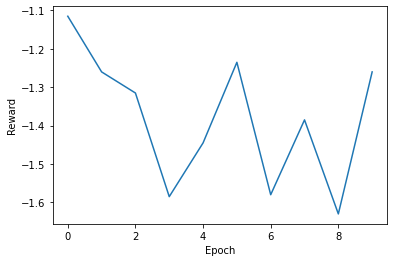

In [26]:
env = MarelleGymEnv(end_after_place_phase=False)

# Models
einstein_fc_model = FCModel(env.N_STATE, env.N_TOTAL_ACTIONS)
einstein_conv_model = ConvModel(env.N_TOTAL_ACTIONS)

# Agents
einstein_fc = SingleModelReinforce(env=env, player_id=1, model=einstein_fc_model, lr=0.005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

einstein_conv = SingleModelReinforce(env=env, player_id=1, model=einstein_conv_model, lr=0.00005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

# Opponents
opponent_agent=BetterRandomAgent(env, -1)
evaluate_agent=BetterRandomAgent(env,-1)

cProfile.run("""train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=20,
    trained_agent=einstein_conv,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=2
)""", sort='tottime')

In [35]:
evaluation_agent = einstein_conv
env.reset()
gabrielle = BetterRandomAgent(env, -1)
piccolo = BetterRandomAgent(env, 1)

cProfile.run("evaluate(env, einstein_conv, gabrielle, 100, 1)", sort="tottime")

         12232816 function calls (12224140 primitive calls) in 7.245 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17261    1.734    0.000    4.569    0.000 marl_env.py:295(move_token_legal_actions)
  3075028    1.500    0.000    1.996    0.000 graph.py:656(nodes)
  3386710    0.559    0.000    0.559    0.000 reportviews.py:186(__getitem__)
  3075028    0.497    0.000    0.497    0.000 reportviews.py:176(__init__)
     6507    0.389    0.000    0.389    0.000 {built-in method conv2d}
   572913    0.384    0.000    0.387    0.000 reportviews.py:1116(__iter__)
   176551    0.363    0.000    0.455    0.000 marl_env.py:325(check_if_capture)
     3152    0.216    0.000    0.600    0.000 marl_env.py:252(place_token_legal_actions)
     2169    0.166    0.000    0.283    0.000 marl_models.py:41(transform_input_to_mat)
     8858    0.165    0.000    0.369    0.000 marl_env.py:227(get_state)
     4338    0.093    0.000    0.093